In [103]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
system_df = pd.read_csv("System Data")

<AxesSubplot:xlabel='monthly consumption', ylabel='original cost'>

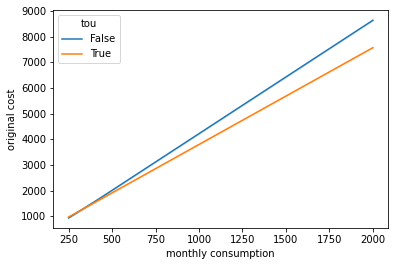

In [105]:
sns.lineplot(data=system_df, x="monthly consumption", y="original cost", hue="tou")

TOU is generally better

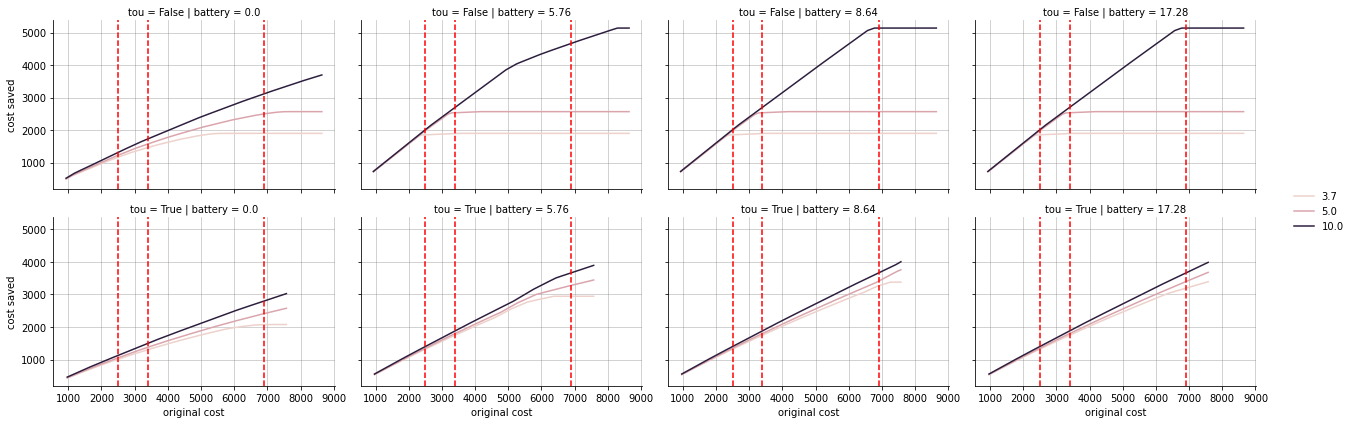

In [114]:
graph1 = sns.FacetGrid(data=system_df, row="tou", col="battery", aspect=1.5)
graph1.map(sns.lineplot, "original cost", "cost saved", "capacity")
graph1.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph1.add_legend()
graph1.map(plt.axvline, x=2500, color="r", linestyle="--")
graph1.map(plt.axvline, x=3400, color="r", linestyle="--")
graph1.map(plt.axvline, x=6900, color="r", linestyle="--")

- No battery
	- Save more money when not using TOU
	- Marginal difference between different capacity, so using 3kW is probably the best
- With battery
	- Having PV is clearly better
	- Having no TOU is clearly better
	- No TOU
		- Higher battery than 5.76 kWh does not make a big difference
		- 3kW is suitable for monthly consumption less than 2,400 THB
		- 5kW is suitable for monthly consumption between 2,400 - 3,200 THB
		- 10kW is suitable for monthly consumption of more than 3,200 THB
	- With TOU
		- Barely any difference between 3kW, 5kW & 10kW, so 3kW is probably better
		- Barely any difference between different battery capacities, so 5.78 kWh is probably better
        

In [118]:
lifespan = 20

def check_case1(row, capacity, battery):
    case1 = (
        (row["capacity"] == capacity) & (row["battery"] == battery) & (row["tou"] == False)
    )
    return case1


def check_case2(row, capacity, battery):
    case2 = (
        (row["capacity"] == capacity) & (row["battery"] == 0) & (row["tou"] == False)
    )
    return case2


def check_case3(row, capacity, battery):
    case3 = (
        (row["capacity"] == capacity)
        & (row["battery"] == battery)
        & (row["tou"] == True)
    )
    return case3


def check_case4(row, capacity, battery):
    case4 = (
        (row["capacity"] == capacity) & (row["battery"] == 0) & (row["tou"] == True)
    )
    return case4


def check_case(row, setup_capacity, setup_battery):
    if check_case1(row, setup_capacity, setup_battery):
        return 1
    if check_case2(row, setup_capacity, setup_battery):
        return 2
    if check_case3(row, setup_capacity, setup_battery):
        return 3
    if check_case4(row, setup_capacity, setup_battery):
        return 4
    return 0


def check_scenario(row):
    capacity_list = [3.7, 5, 10]
    battery_list = [5.76, 8.64, 17.28]
    setup_id_list = list(range(1, len(capacity_list)+1))

    for setup_id, capacity, battery in zip(setup_id_list, capacity_list, battery_list):
        case = check_case(row, capacity, battery)
        if case:
            result = f"{setup_id}.{case}"
            return result
    return None


def get_setup(row):
    if not row["scenario"]:
        return None
    scenario = row["scenario"]
    setup = scenario.split(".")[0]
    return setup


def get_case(row):
    if not row["scenario"]:
        return None
    scenario = row["scenario"]
    case = scenario.split(".")[1]
    return case


def check_cost(row):
    cost_dict = {
        "1.1": 128_460.09,
        "1.2": 72_235.68,
        "1.3": 128_460.09,
        "1.4": 72_235.68,

        "2.1": 169_740.07,
        "2.2": 88_761.09,
        "2.3": 169_740.07,
        "2.4": 88_761.09,

        "3.1": 320_545.92,
        "3.2": 165_303.27,
        "3.3": 320_545.92,
        "3.4": 165_303.27,
    }
    if not row["scenario"]:
        return None
    return cost_dict[row["scenario"]]


def filter_df(df):
    temp = df.copy()

    temp["scenario"] = temp.apply(check_scenario, axis=1)
    temp = temp[temp["scenario"].notna()]

    temp["setup"] = temp.apply(get_setup, axis=1)
    temp["case"] = temp.apply(get_case, axis=1)

    temp["cost"] = temp.apply(check_cost, axis=1)
    temp["payback period"] = temp["cost"] / temp["cost saved"] / 12

    temp["total earning"] = temp["cost saved"] * 12 * lifespan
    temp["net profit"] = temp["total earning"] - temp["cost"]
    temp["roi"] = temp["net profit"] / temp["cost"]
    return temp

df_filtered = filter_df(system_df)
df_filtered

,Unnamed: 0,location name,capacity,egat region,monthly consumption,tou,fit,battery multiplier,battery,location,...,new cost,cost saved,scenario,setup,case,cost,payback period,total earning,net profit,roi
0,0,T3 Technology,3.7,Metropolitan,250,False,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",...,438.549310,495.510690,1.2,1,2,72235.68,12.148355,1.189226e+05,46686.885685,0.646313
1,1,T3 Technology,3.7,Metropolitan,250,False,0,1.556757,5.76,"[13.775369373556686, 100.59884245347287]",...,214.706212,719.353788,1.1,1,1,128460.09,14.881422,1.726449e+05,44184.819236,0.343958
4,4,T3 Technology,3.7,Metropolitan,250,True,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",...,539.640938,428.596448,1.4,1,4,72235.68,14.045007,1.028631e+05,30627.467614,0.423994
5,5,T3 Technology,3.7,Metropolitan,250,True,0,1.556757,5.76,"[13.775369373556686, 100.59884245347287]",...,435.037577,533.199810,1.3,1,3,128460.09,20.076915,1.279680e+05,-492.135714,-0.003831
8,8,T3 Technology,3.7,Metropolitan,260,False,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",...,456.450076,519.827924,1.2,1,2,72235.68,11.580063,1.247587e+05,52523.021648,0.727106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4215,4215,T3 Technology,10.0,Metropolitan,1990,True,0,1.728000,17.28,"[13.775369373556686, 100.59884245347287]",...,3567.474796,3968.339603,3.3,3,3,320545.92,6.731319,9.524015e+05,631855.584608,1.971186
4216,4216,T3 Technology,10.0,Metropolitan,2000,False,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",...,4945.655958,3696.394042,3.2,3,2,165303.27,3.726679,8.871346e+05,721831.300115,4.366709
4219,4219,T3 Technology,10.0,Metropolitan,2000,False,0,1.728000,17.28,"[13.775369373556686, 100.59884245347287]",...,3504.786289,5137.263711,3.1,3,1,320545.92,5.199686,1.232943e+06,912397.370640,2.846386
4220,4220,T3 Technology,10.0,Metropolitan,2000,True,0,0.000000,0.00,"[13.775369373556686, 100.59884245347287]",...,4547.756217,3025.802877,3.4,3,4,165303.27,4.552601,7.261927e+05,560889.420474,3.393093


In [120]:
test = df_filtered[
    (df_filtered["monthly consumption"] == 1600)
    & (df_filtered["capacity"] == 10)
]

test = test.sort_values(by=["scenario"], ascending=True)
test[
    [
        "scenario",
        "capacity",
        "monthly consumption",
        "original cost",
        "new cost",
        "cost saved",
        "payback period",
        "tou",
        "battery",
        "monthly solar energy",
        "net consumption",
        "consumption reduced",
    ]
]

,scenario,capacity,monthly consumption,original cost,new cost,cost saved,payback period,tou,battery,monthly solar energy,net consumption,consumption reduced
3899,3.1,10.0,1600,6873.370000,1736.106289,5137.263711,5.199686,False,17.28,1161.83,438.170000,1161.830000
3896,3.2,10.0,1600,6873.370000,3765.030098,3108.339902,4.431714,False,0.00,1161.83,897.026053,702.973947
3903,3.3,10.0,1600,6063.771275,2811.617892,3252.153383,8.213684,True,17.28,1161.83,1056.922103,543.077897
3900,3.4,10.0,1600,6063.771275,3552.484921,2511.286354,5.485345,True,0.00,1161.83,1056.922103,543.077897


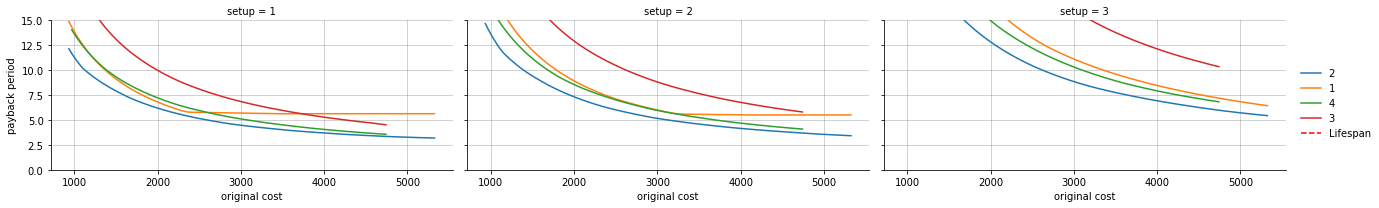

In [75]:
graph2 = sns.FacetGrid(data=df_filtered, col="setup", aspect=2)
graph2.map(sns.lineplot, "original cost", "payback period", "case")
graph2.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph2.map(plt.axhline, y=lifespan, color="r", linestyle="--", label="Lifespan")
graph2.set(ylim=(0, 15))
graph2.add_legend()

We should aim for Payback period of 7 years

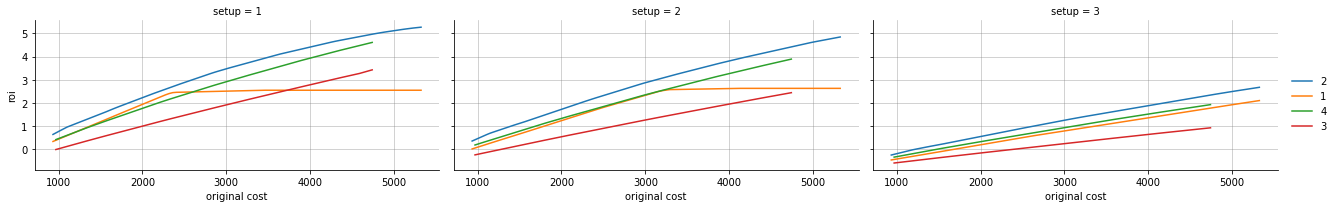

In [76]:
graph3 = sns.FacetGrid(data=df_filtered, col="setup", aspect=2)
graph3.map(sns.lineplot, "original cost", "roi", "case")
graph3.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph3.add_legend()

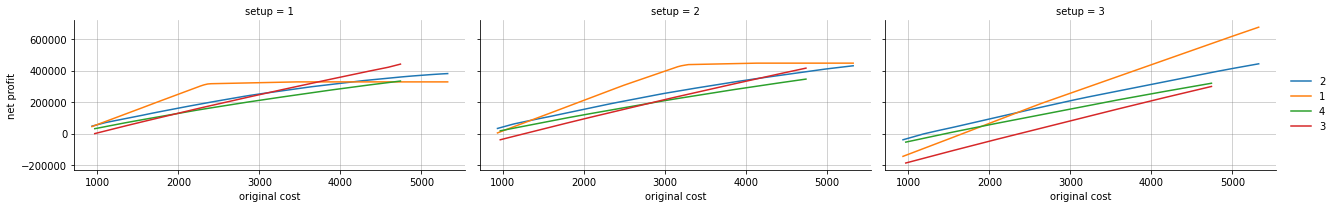

In [77]:
graph4 = sns.FacetGrid(data=df_filtered, col="setup", aspect=2)
graph4.map(sns.lineplot, "original cost", "net profit", "case")
graph4.map(
    lambda *args, **kwargs: plt.grid(True, color="gray", alpha=0.5, linewidth=0.7)
)
graph4.add_legend()